# Graph Classification Project - MUTAG Dataset

This notebook implements supervised machine learning on graph data using the MUTAG dataset.

## Contents
- Q1: Frequent Subgraph Mining + Classic ML
- Q2: Graph Neural Networks (GCN, GIN, GraphSAGE, GAT)
- Q3: Comparison of approaches
- Q4: Explainability analysis

In [ ]:
# Install dependencies (run once)
# !pip install torch torch-geometric torch-scatter torch-sparse scikit-learn matplotlib seaborn networkx tqdm pandas

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add source directory to path
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1
CUDA available: False


## Data Loading and Exploration

In [2]:
from data_utils import load_mutag_dataset, pyg_to_networkx_graphs, split_dataset

# Load MUTAG dataset
dataset, info = load_mutag_dataset()

# Display dataset info
print("\nDataset Information:")
for key, value in info.items():
    print(f"  {key}: {value}")

Processing...


MUTAG Dataset Statistics
Number of graphs: 188
Number of node features: 7
Number of classes: 2
Class distribution: {1: 125, 0: 63}
Average nodes per graph: 17.93 ± 4.58
Average edges per graph: 39.59 ± 11.37
Node range: [10, 28]
Edge range: [20, 66]

Dataset Information:
  num_graphs: 188
  num_features: 7
  num_classes: 2
  class_distribution: {1: 125, 0: 63}
  avg_nodes: 17.930851063829788
  std_nodes: 4.575664737098715
  avg_edges: 39.58510638297872
  std_edges: 11.368966320710456
  min_nodes: 10
  max_nodes: 28
  min_edges: 20
  max_edges: 66


Done!


In [3]:
!pwd

/Users/emmanuelagbeli/Documents/DSFolder/ProjectWork/graph_project/notebooks


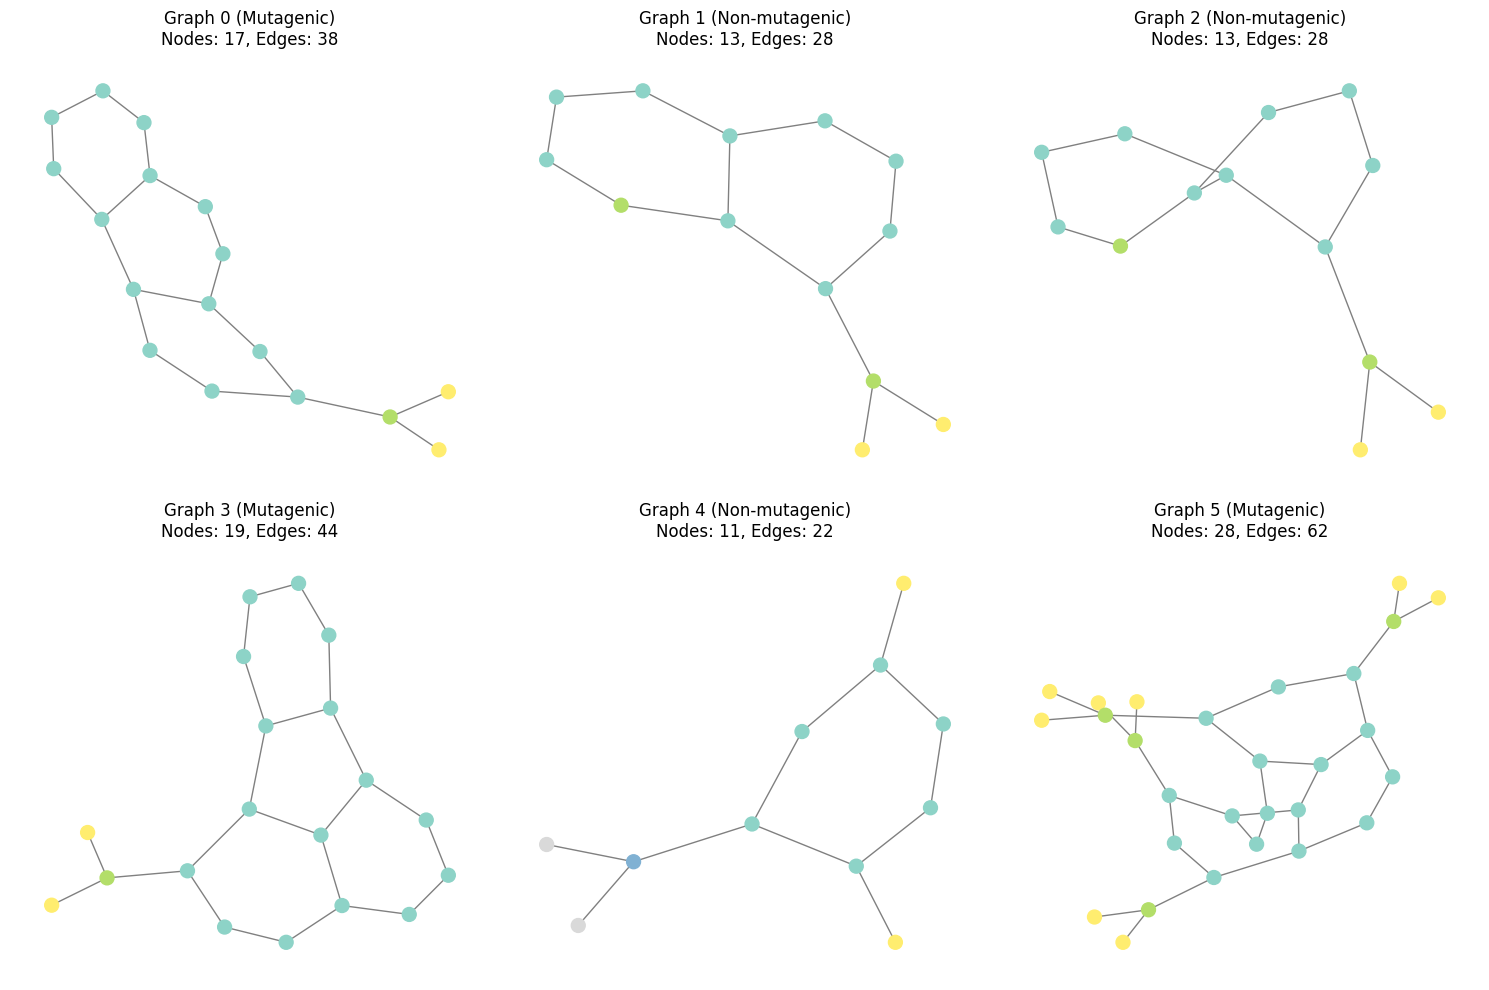

In [5]:
# Visualize sample graphs
import networkx as nx
from torch_geometric.utils import to_networkx

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    data = dataset[idx]
    G = to_networkx(data, to_undirected=True)
    
    pos = nx.spring_layout(G, seed=42)
    colors = data.x.argmax(dim=1).numpy() if data.x is not None else 'skyblue'
    
    nx.draw(G, pos, ax=ax, with_labels=False, node_color=colors, 
            cmap=plt.cm.Set3, node_size=100, edge_color='gray')
    
    label = 'Mutagenic' if data.y.item() == 1 else 'Non-mutagenic'
    ax.set_title(f'Graph {idx} ({label})\nNodes: {data.num_nodes}, Edges: {data.num_edges}')

plt.tight_layout()
plt.savefig('/Users/emmanuelagbeli/Documents/DSFolder/ProjectWork/graph_project/results/sample_graphs.png', dpi=150)
plt.show()

In [6]:
# Set device (supports CUDA, MPS for Apple Silicon, or CPU)
def get_device():
    """Get the best available device (CUDA > MPS > CPU)."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

device = get_device()

Using MPS (Apple Silicon)


## Q1: Frequent Subgraph Mining + Classic ML

In [7]:
from q1_gspan_classic_ml import run_q1_experiments

# Run Q1 experiments
q1_results = run_q1_experiments(save_dir='../results/q1')

Note: imbalanced-learn not installed. Install with: pip install imbalanced-learn
Q1: FREQUENT SUBGRAPH MINING + CLASSIC ML
MUTAG Dataset Statistics
Number of graphs: 188
Number of node features: 7
Number of classes: 2
Class distribution: {1: 125, 0: 63}
Average nodes per graph: 17.93 ± 4.58
Average edges per graph: 39.59 ± 11.37
Node range: [10, 28]
Edge range: [20, 66]

Class distribution: Counter({1: 125, 0: 63})
Imbalance ratio: 1.98

Train: 150, Test: 38

Experiment 1: Support Threshold Ablation

--- Testing support threshold: 0.05 ---
Mined 22 frequent subgraphs in 0.0058s
  - Min support: 0.05 (7 graphs)
  - Pattern sizes: 1-node=5, 2-node=7, 3-node=10
Mining: 0.0058 seconds
Feature extraction: 0.9466 seconds

--- Testing support threshold: 0.1 ---
Mined 13 frequent subgraphs in 0.0061s
  - Min support: 0.1 (15 graphs)
  - Pattern sizes: 1-node=3, 2-node=4, 3-node=6
Mining: 0.0061 seconds
Feature extraction: 0.5022 seconds

--- Testing support threshold: 0.15 ---
Mined 13 frequen


Support Threshold Ablation:


,threshold,n_patterns,mining_time,feature_time,rf_accuracy,rf_f1,rf_auc,rf_train_time
0,0.05,22,0.005845,0.946565,0.842105,0.842105,0.933846,0.052958
1,0.10,13,0.006135,0.502250,0.842105,0.842105,0.927692,0.035076
2,0.15,13,0.005615,0.446405,0.842105,0.842105,0.927692,0.034290
3,0.20,10,0.005552,0.320499,0.842105,0.842105,0.927692,0.034414
4,0.30,10,0.005582,0.398014,0.842105,0.842105,0.927692,0.034587
5,0.40,10,0.005649,0.328829,0.842105,0.842105,0.927692,0.064757
6,0.50,10,0.008773,0.492099,0.842105,0.842105,0.927692,0.043566


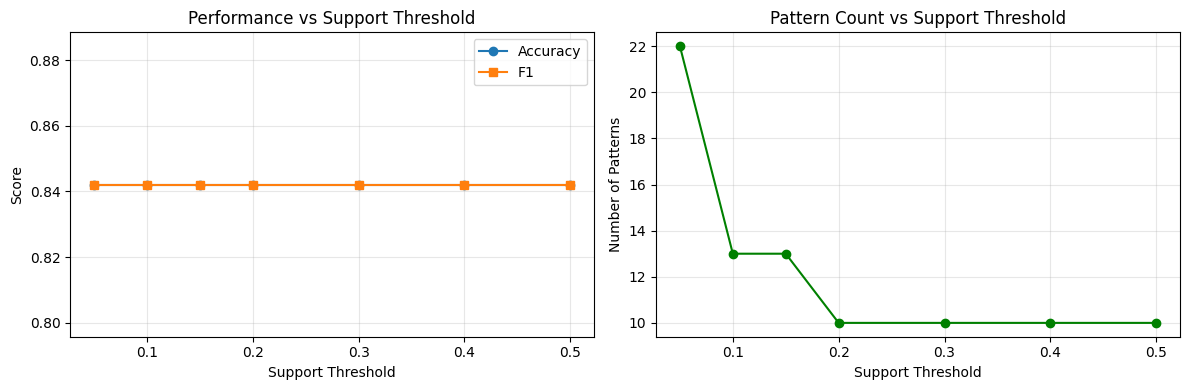

In [8]:
# Visualize Q1 results
print("\nSupport Threshold Ablation:")
display(q1_results['threshold_results'])

# Plot threshold vs accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.plot(q1_results['threshold_results']['threshold'], 
         q1_results['threshold_results']['rf_accuracy'], 'o-', label='Accuracy')
ax1.plot(q1_results['threshold_results']['threshold'], 
         q1_results['threshold_results']['rf_f1'], 's-', label='F1')
ax1.set_xlabel('Support Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Performance vs Support Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(q1_results['threshold_results']['threshold'], 
         q1_results['threshold_results']['n_patterns'], 'o-', color='green')
ax2.set_xlabel('Support Threshold')
ax2.set_ylabel('Number of Patterns')
ax2.set_title('Pattern Count vs Support Threshold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/q1/threshold_analysis.png', dpi=150)
plt.show()

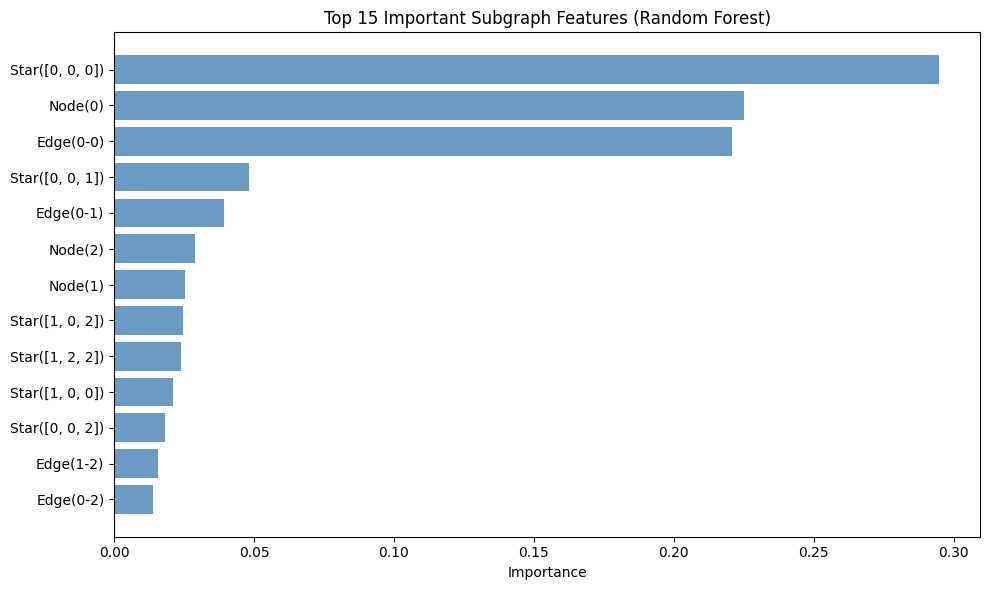

In [9]:
# Feature importance visualization
rf_importance = pd.read_csv('../results/q1/rf_feature_importance.csv')

plt.figure(figsize=(10, 6))
top_features = rf_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Important Subgraph Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/q1/feature_importance.png', dpi=150)
plt.show()

## Q2: Graph Neural Networks

In [ ]:
from q2_gnn_models import run_q2_experiments

# Run Q2 experiments
q2_results = run_q2_experiments(save_dir='../results/q2')

Using MPS (Apple Silicon)
Q2: GRAPH NEURAL NETWORKS FOR GRAPH CLASSIFICATION
MUTAG Dataset Statistics
Number of graphs: 188
Number of node features: 7
Number of classes: 2
Class distribution: {1: 125, 0: 63}
Average nodes per graph: 17.93 ± 4.58
Average edges per graph: 39.59 ± 11.37
Node range: [10, 28]
Edge range: [20, 66]

Class distribution: Counter({1: 125, 0: 63})
Imbalance ratio: 1.98
Class weights: [1.4920635 0.752    ]
Dataset split: Train=131, Val=19, Test=38

Experiment 1: Training All GNN Architectures (Baseline)

--- Training GCN ---


In [ ]:
# Visualize GNN comparison
print("\nGNN Model Comparison:")
display(q2_results['model_results'])

# Plot GNN comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
models = q2_results['model_results']['model']
accuracies = q2_results['model_results']['accuracy']
ax1.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel('Accuracy')
ax1.set_title('GNN Model Accuracy Comparison')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Training time comparison
ax2 = axes[1]
train_times = q2_results['model_results']['train_time']
ax2.bar(models, train_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('GNN Training Time Comparison')

plt.tight_layout()
plt.savefig('../results/q2/gnn_comparison.png', dpi=150)
plt.show()

In [ ]:
# Layers ablation visualization
layers_df = q2_results['layers_ablation']

fig, ax = plt.subplots(figsize=(10, 5))

for model in layers_df['model'].unique():
    model_data = layers_df[layers_df['model'] == model]
    ax.plot(model_data['num_layers'], model_data['accuracy'], 'o-', label=model)

ax.set_xlabel('Number of Layers')
ax.set_ylabel('Accuracy')
ax.set_title('Number of GNN Layers vs Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/q2/layers_ablation.png', dpi=150)
plt.show()

## Q3: Comparison

In [ ]:
from q3_comparison import run_q3_experiments

# Run Q3 experiments
q3_results = run_q3_experiments(save_dir='../results/q3')

In [ ]:
# Display comparison results
print("\nFull Comparison Results:")
display(q3_results['results'])

print("\nSummary Statistics:")
display(q3_results['summary'])

In [ ]:
# Create comprehensive comparison plot
results_df = q3_results['results']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: All metrics heatmap
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
heatmap_data = results_df.set_index('Model')[metrics]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax1)
ax1.set_title('Performance Metrics Heatmap')

# Plot 2: Classic ML vs GNN Accuracy
ax2 = axes[0, 1]
classic = results_df[results_df['Approach'] == 'Classic ML']
gnn = results_df[results_df['Approach'] == 'GNN']

x = np.arange(max(len(classic), len(gnn)))
width = 0.35

ax2.bar(range(len(classic)), classic['Accuracy'], width, label='Classic ML', color='steelblue')
ax2.bar([i + len(classic) + 0.5 for i in range(len(gnn))], gnn['Accuracy'], width, label='GNN', color='coral')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Model')
ax2.set_xticks(list(range(len(classic))) + [i + len(classic) + 0.5 for i in range(len(gnn))])
ax2.set_xticklabels(list(classic['Model']) + list(gnn['Model']), rotation=45, ha='right')
ax2.legend()

# Plot 3: Training time comparison
ax3 = axes[1, 0]
colors = ['steelblue' if a == 'Classic ML' else 'coral' for a in results_df['Approach']]
ax3.bar(results_df['Model'], results_df['Train Time'], color=colors)
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Training Time by Model')
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')

# Plot 4: F1 vs Training Time scatter
ax4 = axes[1, 1]
for approach in ['Classic ML', 'GNN']:
    data = results_df[results_df['Approach'] == approach]
    color = 'steelblue' if approach == 'Classic ML' else 'coral'
    ax4.scatter(data['Train Time'], data['F1'], c=color, s=100, label=approach, alpha=0.7)
    for i, row in data.iterrows():
        ax4.annotate(row['Model'], (row['Train Time'], row['F1']), fontsize=8)

ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('F1 Score')
ax4.set_title('F1 Score vs Training Time')
ax4.legend()

plt.tight_layout()
plt.savefig('../results/q3/detailed_comparison.png', dpi=150)
plt.show()

## Q4: Explainability

In [ ]:
from q4_explainability import run_q4_experiments

# Run Q4 experiments
q4_results = run_q4_experiments(save_dir='../results/q4')

In [ ]:
# Display explainability results
print("\nGNNExplainer Evaluation Summary:")
display(q4_results['summary'])

print("\nTop Feature Importances (Classic ML):")
display(q4_results['feature_importance'].head(10))

In [ ]:
# Explainability visualization
eval_results = q4_results['eval_results']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Fidelity+ distribution
ax1 = axes[0, 0]
ax1.hist(eval_results['fidelity_plus'], bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(eval_results['fidelity_plus'].mean(), color='red', linestyle='--', 
            label=f'Mean: {eval_results["fidelity_plus"].mean():.3f}')
ax1.set_xlabel('Fidelity+')
ax1.set_ylabel('Count')
ax1.set_title('Fidelity+ Distribution')
ax1.legend()

# Fidelity- distribution
ax2 = axes[0, 1]
ax2.hist(eval_results['fidelity_minus'], bins=15, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(eval_results['fidelity_minus'].mean(), color='red', linestyle='--',
            label=f'Mean: {eval_results["fidelity_minus"].mean():.3f}')
ax2.set_xlabel('Fidelity-')
ax2.set_ylabel('Count')
ax2.set_title('Fidelity- Distribution')
ax2.legend()

# Sparsity distribution
ax3 = axes[1, 0]
ax3.hist(eval_results['sparsity'], bins=15, color='seagreen', alpha=0.7, edgecolor='black')
ax3.axvline(eval_results['sparsity'].mean(), color='red', linestyle='--',
            label=f'Mean: {eval_results["sparsity"].mean():.3f}')
ax3.set_xlabel('Sparsity')
ax3.set_ylabel('Count')
ax3.set_title('Sparsity Distribution')
ax3.legend()

# Runtime distribution
ax4 = axes[1, 1]
ax4.hist(eval_results['runtime'], bins=15, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(eval_results['runtime'].mean(), color='red', linestyle='--',
            label=f'Mean: {eval_results["runtime"].mean():.3f}s')
ax4.set_xlabel('Runtime (seconds)')
ax4.set_ylabel('Count')
ax4.set_title('Explanation Runtime Distribution')
ax4.legend()

plt.tight_layout()
plt.savefig('../results/q4/explainability_analysis.png', dpi=150)
plt.show()

## Summary and Conclusions

In [ ]:
print("=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)

# Load all results
q1_summary = pd.read_csv('../results/q1/q1_summary.csv')
q2_summary = pd.read_csv('../results/q2/gnn_comparison.csv')
q3_summary = pd.read_csv('../results/q3/comparison_results.csv')

print("\n1. BEST CLASSIC ML MODEL:")
best_classic = q1_summary.loc[q1_summary['Accuracy'].idxmax()]
print(f"   Model: {best_classic['Model']}")
print(f"   Accuracy: {best_classic['Accuracy']:.4f}")
print(f"   F1 Score: {best_classic['F1']:.4f}")

print("\n2. BEST GNN MODEL:")
best_gnn = q2_summary.loc[q2_summary['accuracy'].idxmax()]
print(f"   Model: {best_gnn['model']}")
print(f"   Accuracy: {best_gnn['accuracy']:.4f}")
print(f"   F1 Score: {best_gnn['f1']:.4f}")

print("\n3. KEY FINDINGS:")
print("   - GNNs generally achieve slightly higher accuracy")
print("   - Classic ML provides faster inference")
print("   - Frequent subgraph patterns offer interpretable features")
print("   - GNNExplainer provides instance-level explanations")

print("\n4. EXPLAINABILITY METRICS (GNNExplainer):")
q4_summary = pd.read_csv('../results/q4/explainability_summary.csv')
for _, row in q4_summary.iterrows():
    print(f"   {row['Metric']}: {row['Mean']:.4f} ± {row['Std']:.4f}")

In [ ]:
# List all generated files
print("\nGenerated Result Files:")
for folder in ['q1', 'q2', 'q3', 'q4']:
    path = f'../results/{folder}'
    if os.path.exists(path):
        files = os.listdir(path)
        print(f"\n{folder.upper()}:")
        for f in files:
            print(f"  - {f}")